#### **Bước 1. Phân tích các phương thức có trong chương trình**
**Bài toán:** Mã OTP là không thể phá vỡ được, nhưng bạn có thể khôi phục được cờ không? (Gói bằng picoCTF{})

**Hint:** 
- Có lẽ có cách nào đó để biến nó thành miếng lót 2x


##### ***1.1. Phân tích các đoạn trong chương trình `otp.py`***


- `KEY_FILE`: tên file chứa khóa dùng để mã hóa.
- `KEY_LEN`: độ dài khóa là 50.000 byte.
- `FLAG_FILE`: tên file chứa flag (chuỗi thông điệp hoặc dữ liệu quan trọng) cần mã hóa và hiển thị dưới dạng mã hóa.

In [ ]:
import os.path

KEY_FILE = "key"
KEY_LEN = 50000
FLAG_FILE = "flag"

Phương thức thực hiện mã hóaflag từ file `flag` và in ra kết quả mã hóa.
- 1. Đọc file `flag` dạng bình thường, `key` dạng nhị phân
- 2. lấy độ dài khóa bằng độ dài chuỗi tính từ `key_location` cho trước
- 3. Thực hiện mã hóa và đưa ra một list các byte biểu diễn dạng HEX, thực hiện phép **`XOR`** từng ký tự giữa `flag` và `key`. Trả về vị trí hiện tại của `key`
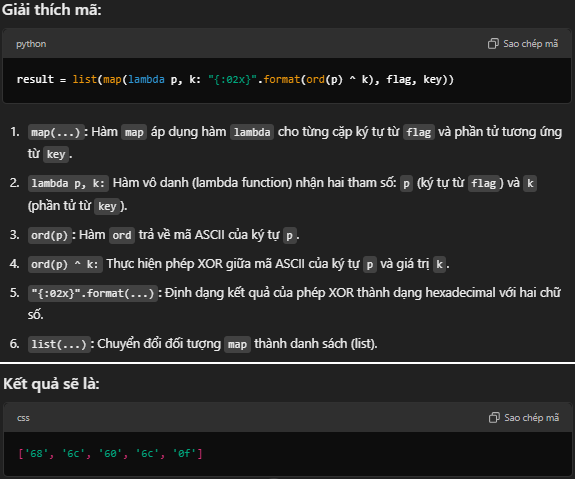

Khi thực hiện thì phương thức `map` thực hiện với chuỗi ngắn hơn

In [ ]:
def startup(key_location):
	flag = open(FLAG_FILE).read()
	kf = open(KEY_FILE, "rb").read()

	start = key_location
	stop = key_location + len(flag)

	key = kf[start:stop]
	key_location = stop

	result = list(map(lambda p, k: "{:02x}".format(ord(p) ^ k), flag, key))
	print("This is the encrypted flag!\n{}\n".format("".join(result)))

	return key_location

Phương thức cho phép người dùng nhập một chuỗi dữ liệu. Sau đó cho phép mã hóa chuỗi đó dựa trên khóa trong file. Tương tự phương thức `startup(key_location)`

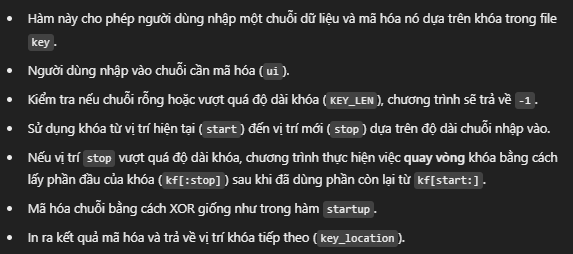

In [ ]:
def encrypt(key_location):
	ui = input("What data would you like to encrypt? ").rstrip()
	if len(ui) == 0 or len(ui) > KEY_LEN:
		return -1

	start = key_location
	stop = key_location + len(ui)

	kf = open(KEY_FILE, "rb").read()

	if stop >= KEY_LEN:
		stop = stop % KEY_LEN
		key = kf[start:] + kf[:stop]
	else:
		key = kf[start:stop]
	key_location = stop

	result = list(map(lambda p, k: "{:02x}".format(ord(p) ^ k), ui, key))

	print("Here ya go!\n{}\n".format("".join(result)))

	return key_location

#### **Bước 2. Phân tích**



##### ***2.1. Phân tích chương trình***
- Có thể thấy, bài toán mã hóa flag với key cùng độ dài và bắt đầu từ 0. 
- Tiếp theo, từng ký tự của `key` được `XOR` với từng ký tự của `flag` và đưa ra kết quả.

`=>` Do đó, nếu ta dùng flag để thực hiện một startup thì dữ liệu sẽ `XOR` với `key` 2 lần, và trả về `flag` 

**Vấn đề đặt ra:**
- 1. Ta chưa biết độ dài của `key`, dựa vào độ dài của flag, ta đoán độ dài của `flag`, từ đó trả về và ta dự đoán độ dài của `key`.
- **Chữa:** Đọc đề bài không kỹ `KEY_LEN = 50000`, do đó, ta đã có độ dìa của `key`

Bây giờ, ta thực hiện lấy đoạn cipher được mã hóa.

In [8]:
from pwn import *
from Crypto.Util.number import *
import subprocess

# Tạo một conection remote:
port = 58913
r = remote('mercury.picoctf.net', port)

get_success = r.recvuntil('This is the encrypted flag!\n').decode()
flag_enc = r.recvline(keepends=False).strip().decode()
print(flag_enc)
print(len(flag_enc)//2)         # 32


# Đóng chương trình:
# r.close()

[x] Opening connection to mercury.picoctf.net on port 58913
[x] Opening connection to mercury.picoctf.net on port 58913: Trying 18.189.209.142
[+] Opening connection to mercury.picoctf.net on port 58913: Done


C:\Users\Dell\AppData\Local\Temp\ipykernel_18788\249714301.py:9: BytesWarning: Text is not bytes; assuming ASCII, no guarantees. See https://docs.pwntools.com/#bytes
  get_success = r.recvuntil('This is the encrypted flag!\n').decode()


51124f4d194969633e4b52026f4c07513a6f4d05516e1e50536c4954066a1c57
32


Có thể thấy, độ dài của `flag` là 32. 

Ta có, như vậy, độ dài của `key` còn `50000 - 32 = 49968`. Ta tạo một chuỗi toàn `a` với độ dài `49968`. Đưa vào máy mã hóa.

Cuối cùng ta cho chương trình mã hóa tiếp lại `flag` ta thu được `flag`

In [10]:
from pwn import *
from Crypto.Util.number import *
import subprocess
from IPython.display import clear_output

def hex2dec_ascii(hex_str):
    hexs_lst = [hex_str[i:i+2] for i in range(0, len(hex_str), 2)]
    
    decs_lst = []
    ascs_lst = []
    
    for hexa in hexs_lst:
        dec_value = int(hexa, 16)  # Chuyển đổi từ hex sang dec
        decs_lst.append(dec_value)
        ascs_lst.append(chr(dec_value))  # Chuyển đổi từ dec sang ký tự ASCII
    return decs_lst, ascs_lst


# Tạo một conection remote:
port = 58913
r = remote('mercury.picoctf.net', port)

get_success = r.recvuntil('This is the encrypted flag!\n').decode()
flag_enc = r.recvline(keepends=False).strip().decode()
print(flag_enc)
print(len(flag_enc)//2)         # 32

_, ascii_flag = hex2dec_ascii(flag_enc)
ascii_flag = "".join(ascii_flag)
print(ascii_flag, type(ascii_flag))

# Lấy chuỗi này nhân 1561, cộng với 16 ký tự đầu của chuỗi
temp_enc = 'a'* (50000 - len(flag_enc)//2)

get_success = r.recvuntil('like to encrypt?').decode()
r.sendline(temp_enc)                # r.send('pi\n`)
get_success = r.recvuntil('Here ya go!\n').decode()
char2_enc = r.recvline(keepends=False).strip().decode()
print(char2_enc)

get_success = r.recvuntil('like to encrypt?').decode()
r.sendline(ascii_flag)               
get_success = r.recvuntil('Here ya go!\n').decode()
char2_enc = r.recvline(keepends=False).strip().decode()
print(char2_enc)

_, flags = hex2dec_ascii(char2_enc) 

# Xóa stdout
clear_output(wait=True)

print("".join(flags))

35ecb423b3b43472c35cc2f41011c6d2
